# Notebook 0: Generate AnnData objects and examine dataset statistics

This notebook generates the anndata objects for the training, validation, and test sets. We also examine label and cell distribution of samples in each dataset.

Note that in this notebook, 0 refers to normal cells and 1 refers to cancer cells.

In [1]:
# Imports

import main_functions as mf
import os
from pathlib import Path
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/gylam/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up working directory
folder_path = input('Please enter the path of the folder containing datasets: ')
os.chdir(folder_path)

Please enter the path of the folder containing datasets:  ../data/


## Training dataset (Qian et al., 2020, EMTAB8107)

In [ ]:
# Create anndata object using original and TISCH count matrices and original labels
adata_train = mf.create_adata('EMTAB8107_2102-Breastcancer_counts',
                              'BRCA_EMTAB8107_expression.h5',
                              'EMTAB8107_2103-Breastcancer_metadata.csv.gz')

# Save to h5ad
#adata_train.write_h5ad('train.h5ad')

In [3]:
# Read in saved anndata object
adata_train = sc.read_h5ad('train.h5ad')
print(adata_train)
display(adata_train.obs.head())

AnnData object with n_obs × n_vars = 33043 × 22830
    obs: 'nGene', 'nUMI', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'orig_cancer_label'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'norm', 'raw'


,nGene,nUMI,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType,orig_cancer_label
sc5rJUQ024_AAACCTGCAACAACCT,894,1624,True,41,BC,Biopsy,DC,0
sc5rJUQ024_AAACCTGCAAGAAGAG,1401,2983,True,41,BC,Biopsy,T_cell,0
sc5rJUQ024_AAACCTGGTCTCCACT,585,1141,True,41,BC,Biopsy,Cancer,1
sc5rJUQ024_AAACCTGTCAACGAAA,4233,18953,True,41,BC,Biopsy,Myeloid,0
sc5rJUQ024_AAACGGGAGAGTAAGG,1669,3794,True,41,BC,Biopsy,Fibroblast,0


In [4]:
# Get total number of cells and % cancer for dataset
adata_train.obs['orig_cancer_label'].value_counts('orig_cancer_label', sort = False).reset_index()

,orig_cancer_label,proportion
0,0,0.757407
1,1,0.242593


In [5]:
# Show breakdown of number of cells and % cancer by patient
adata_train_grp_counts = adata_train.obs.groupby('PatientNumber')['PatientNumber'].value_counts().reset_index()
adata_train_grp_counts['perc'] = adata_train_grp_counts['count']/adata_train_grp_counts['count'].sum()
adata_train_grp_counts = adata_train_grp_counts.sort_values('perc', ascending = False)
adata_train_grp_counts

,PatientNumber,count,perc
13,54,3978,0.120389
2,43,3848,0.116454
4,45,3786,0.114578
0,41,3426,0.103683
10,51,3183,0.096329
12,53,3136,0.094907
8,49,3018,0.091336
3,44,2297,0.069515
1,42,2216,0.067064
7,48,1778,0.053809


In [6]:
# Get % cancer breakdown by patient
adata_train.obs.groupby('PatientNumber')['orig_cancer_label'].value_counts('orig_cancer_label', sort = False).reset_index()

,PatientNumber,orig_cancer_label,proportion
0,41,0,0.972855
1,41,1,0.027145
2,42,0,0.886733
3,42,1,0.113267
4,43,0,0.900208
5,43,1,0.099792
6,44,0,0.916848
7,44,1,0.083152
8,45,0,0.849709
9,45,1,0.150291


In [7]:
# Percent cancer and normal cells contributed by each patient to the overall dataset
adata_train.obs.groupby('orig_cancer_label')['PatientNumber'].value_counts(normalize = True)

orig_cancer_label  PatientNumber
0                  43               0.138411
                   41               0.133176
                   45               0.128541
                   53               0.111759
                   49               0.098414
                   51               0.094977
                   44               0.084149
                   42               0.078515
                   48               0.060295
                   50               0.028529
                   54               0.014265
                   47               0.013266
                   52               0.010828
                   46               0.004875
1                  54               0.451722
                   47               0.103044
                   51               0.100549
                   45               0.070983
                   49               0.069237
                   43               0.047904
                   53               0.042290
                   48 

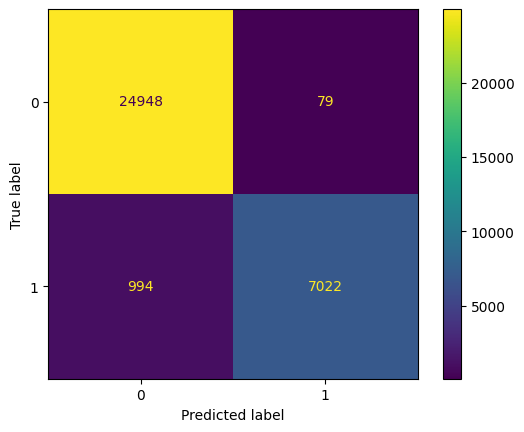

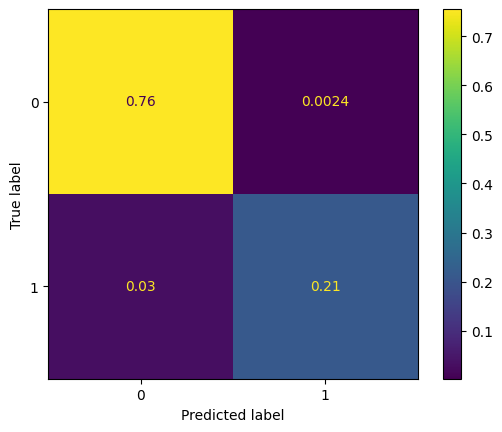

In [8]:
# Show discrepancy between original and TISCH labels using confusion matrix

# Load in TISCH metadata
adata_train_tisch_meta = pd.read_csv('BRCA_EMTAB8107_CellMetainfo_table.tsv', sep='\t', index_col = 0)
adata_train_tisch_meta['tisch_label'] = np.where(
    adata_train_tisch_meta['Celltype (malignancy)'] == 'Malignant cells', 1, 0)

# Merge original metadata with TISCH metadata
adata_train_meta_merged = pd.merge(adata_train_tisch_meta, adata_train.obs,
                                   left_index = True, right_index = True, how = 'inner')

# Compare number of matching labels using confusion matrix
conf_matrix_labels = confusion_matrix(
    adata_train_meta_merged['orig_cancer_label'],
    adata_train_meta_merged['tisch_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_labels)
disp.plot();

conf_matrix_labels_norm = confusion_matrix(
    adata_train_meta_merged['orig_cancer_label'],
    adata_train_meta_merged['tisch_label'],
    normalize = 'all')
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_labels_norm)
disp.plot();

### Summary
* Majority of cells (~75%) are normal, which is reflected in label breakdown by patient, except for patients 47 and 54
* About half patients contribute equally to cancer cells, while one patient (54) contributes large portion of normal cells (~45%)
* 3.2% of TISCH labels do not match original labels, with 3% of TISCH labels for normal cells being labeled as 'cancer' in original dataset

## Validation dataset (Gao et al., 2021, GSE148673)

In [ ]:
# From original files provided by the authors on GEO,
# concatenate raw counts and labels from all patients into a single file

# For each .txt.gz file in directory, read in the count matrix and corresponding label
dir_list = Path('GSE148673_RAW').glob('**/*.txt.gz')
obj_dict = {}

for i, curr_file_path in enumerate(dir_list):
  curr_filename = Path(curr_file_path.name).stem
  base_name = curr_filename.split('_')[0]
  curr_df = sc.read_text(curr_file_path, dtype = 'str').to_df().transpose()
  curr_df = curr_df.add_prefix(f'{base_name}@', axis=0)
  # Add column for patient number
  curr_df['PatientNumber'] = base_name
  obj_dict[i] = curr_df

# Concatenate counts and labels from all AnnData objects
val_df = pd.concat(obj_dict.values(), ignore_index=False).fillna(0)
print(val_df.shape)
display(val_df.head())

In [ ]:
# Separate labels and counts into separate dataframes
labels = ['copykat.pred', 'cluster.pred', 'PatientNumber']
df_labels = val_df[labels]
df_counts = val_df.drop(labels, axis = 1)
df_counts = df_counts.apply(pd.to_numeric)
#df_counts.to_csv('GSE148673_test.csv.gz')

# Create new label column - orig_cancer_labels. Tumor if copykat and cluster agree, Normal otherwise
df_labels.index.name = 'Cell'
df_labels['CellType'] = np.where((df_labels['copykat.pred'] == 'T') & \
                                          (df_labels['cluster.pred'] == 'T'),
                                          'Cancer', 'Normal')
#df_labels.to_csv('GSE148673_labels.csv')

In [ ]:
# Generate anndata object with raw and normalized counts
adata_val = mf.create_adata('GSE148673_test.csv.gz',
                         'BRCA_GSE148673_expression.h5',
                         'GSE148673_labels.csv')
# adata_val.write_h5ad('val.h5ad')

In [9]:
adata_val = sc.read_h5ad('val.h5ad')
print(adata_val)
adata_val.obs.head()

AnnData object with n_obs × n_vars = 10359 × 19203
    obs: 'copykat.pred', 'cluster.pred', 'PatientNumber', 'CellType', 'orig_cancer_label'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'norm', 'raw'


,copykat.pred,cluster.pred,PatientNumber,CellType,orig_cancer_label
GSM4476486@AAACCTGCACCTTGTC,T,T,GSM4476486,Cancer,1
GSM4476486@AAACGGGAGTCCTCCT,N,N,GSM4476486,Normal,0
GSM4476486@AAACGGGTCCAGAGGA,T,T,GSM4476486,Cancer,1
GSM4476486@AAAGATGCAGTTTACG,T,T,GSM4476486,Cancer,1
GSM4476486@AAAGCAACAGGAATGC,T,T,GSM4476486,Cancer,1


In [10]:
# Get total number of cells and % cancer for dataset
adata_val.obs['orig_cancer_label'].value_counts('orig_cancer_label', ascending = True).reset_index()

,orig_cancer_label,proportion
0,0,0.383242
1,1,0.616758


In [11]:
# Show breakdown of number of cells and % cancer by patient
adata_val.obs['PatientNumber'] = adata_val.obs['PatientNumber'].astype(str)
adata_val_grp_counts = adata_val.obs.groupby('PatientNumber')['PatientNumber'].value_counts().reset_index()
adata_val_grp_counts['perc'] = adata_val_grp_counts['count']/adata_val_grp_counts['count'].sum()
adata_val_grp_counts = adata_val_grp_counts.sort_values('perc', ascending = False)
adata_val_grp_counts

,PatientNumber,count,perc
5,GSM4476490,3217,0.310551
4,GSM4476489,2999,0.289507
0,GSM4476485,1480,0.142871
1,GSM4476486,1097,0.105898
2,GSM4476487,1034,0.099817
3,GSM4476488,532,0.051356


In [12]:
# Get % cancer breakdown by patient
adata_val.obs.groupby('PatientNumber')['orig_cancer_label'].value_counts('orig_cancer_label', sort = False).reset_index()

,PatientNumber,orig_cancer_label,proportion
0,GSM4476485,0,0.306757
1,GSM4476485,1,0.693243
2,GSM4476486,0,0.278031
3,GSM4476486,1,0.721969
4,GSM4476487,0,0.402321
5,GSM4476487,1,0.597679
6,GSM4476488,0,0.661654
7,GSM4476488,1,0.338346
8,GSM4476489,0,0.618873
9,GSM4476489,1,0.381127


In [13]:
# Percent cancer and normal cells contributed by each patient to the overall dataset
adata_val.obs.groupby('orig_cancer_label')['PatientNumber'].value_counts(normalize = True)

orig_cancer_label  PatientNumber
0                  GSM4476489       0.467506
                   GSM4476490       0.147859
                   GSM4476485       0.114358
                   GSM4476487       0.104786
                   GSM4476488       0.088665
                   GSM4476486       0.076826
1                  GSM4476490       0.411645
                   GSM4476489       0.178901
                   GSM4476485       0.160589
                   GSM4476486       0.123963
                   GSM4476487       0.096729
                   GSM4476488       0.028173
Name: proportion, dtype: float64

### Summary
* Unlike training set, this dataset has mostly cancer cells (~62%)
* One patient contributes ~45% of cancer cells, and a different patient contributes ~40% of normal cells

## Test dataset (Chi et al., 2020, GSE150660)

In [ ]:
# Combine raw counts and metadata for each patient into a single file

# Navigate to directory with raw counts and metadata
data_path = 'GSE150660_RAW/'
paths = Path(data_path).glob('**/*.csv.gz')

adata_norm_all = sc.AnnData()
raw_counts_all = pd.DataFrame()

# Loop through each patient
for i, curr_file in enumerate(paths):
    curr_filename = curr_file.name
    curr_patient_id = curr_filename.split('_')[0]

    # Load in csv.gz (raw counts)
    curr_csv_raw = pd.read_csv(curr_file)
    curr_csv_raw = (curr_csv_raw.rename(columns = {'Unnamed: 0': 'cell_id'})
                                .drop('CLUSTER', axis = 1))
    # Update index names from csv.gz to match TISCH index format (sample_id@cell_id)
    curr_csv_raw['cell_id'] = curr_csv_raw['cell_id'].astype(str)
    curr_csv_raw['cell_id'] = curr_csv_raw['cell_id'].apply(lambda x: f'{curr_patient_id}@{x}')
    curr_csv_raw = curr_csv_raw.set_index('cell_id')
    # Calculate n_counts and n_genes - use to merge with h5ad
    n_counts = curr_csv_raw.sum(axis = 1)
    n_genes = (curr_csv_raw > 0).sum(axis = 1)
    curr_csv_raw['n_counts'] = n_counts
    curr_csv_raw['n_genes'] = n_genes
    curr_csv_raw = curr_csv_raw.reset_index()

    # Load in h5ad (normalized counts with metadata from paper)
    curr_h5ad_norm = sc.read_h5ad(f'{data_path}{curr_filename.split(".")[0]}.h5ad')
    curr_h5ad_norm.obs = curr_h5ad_norm.obs.rename(columns = {'Patient': 'PatientNumber'})
    # Convert n_counts and n_genes columns to int so can merge with csv.gz
    curr_h5ad_norm.obs['n_counts'] = curr_h5ad_norm.obs['n_counts'].astype('int64')
    # Convert cell type column into binary 0/1 for normal/cancer
    curr_h5ad_norm.obs['orig_cancer_label'] = np.where(curr_h5ad_norm.obs['labels'].str.contains('Cancer'), 1, 0)

    # Merge csv.gz with h5ad.obs on n_counts and n_genes - inner join (same cells)
    curr_csv_raw_sub = pd.merge(curr_csv_raw, curr_h5ad_norm.obs[['n_counts', 'n_genes']], how = 'inner',
                                on = ['n_counts', 'n_genes'])
    curr_csv_raw_sub = curr_csv_raw_sub.drop_duplicates(subset = 'cell_id')
    curr_csv_raw_sub = curr_csv_raw_sub.drop(columns = ['n_counts', 'n_genes'])
    # Update h5ad indices to csv.gz index
    curr_h5ad_norm.obs.index = curr_csv_raw_sub['cell_id']

    # Concatenate raw and h5ad objects
    raw_counts_all = pd.concat([raw_counts_all, curr_csv_raw_sub], axis = 0).fillna(0)
    if i == 0:
        adata_norm_all = curr_h5ad_norm.copy()
    else:
        adata_norm_all = ad.concat([adata_norm_all, curr_h5ad_norm], uns_merge = 'unique', index_unique = None)
raw_counts_all = raw_counts_all.set_index('cell_id')

In [ ]:
# Load in TISCH dataset - subset to same cells and features as norm
tisch_counts = sc.read_10x_h5('BRCA_GSE150660_expression.h5', gex_only = False)

tisch_counts.obs['in_tisch'] = tisch_counts.obs.index.isin(adata_norm_all.obs_names)
tisch_counts.var['in_tisch'] = tisch_counts.var.index.isin(adata_norm_all.var_names)
tisch_sub = tisch_counts[tisch_counts.obs['in_tisch'], tisch_counts.var['in_tisch']].copy()

# Merge cell labels to TISCH obs
tisch_sub.obs = pd.merge(tisch_sub.obs, adata_norm_all.obs, left_index = True, right_index = True)

# Subset raw to same features as TISCH
raw_counts_sub = raw_counts_all.loc[
    raw_counts_all.index[raw_counts_all.index.isin(tisch_sub.obs_names)],
    raw_counts_all.columns[raw_counts_all.columns.isin(tisch_sub.var_names)]]

# Save Anndata object
adata_all = tisch_sub.copy()
adata_all.layers['norm'] = tisch_sub.X.copy()
adata_all.layers['raw'] = raw_counts_sub.copy()

adata_all.obs = adata_all.obs.drop(columns = ['in_tisch'])
adata_all.var = adata_all.var.drop(columns = ['in_tisch'])
adata_all.write_h5ad('test.h5ad')

In [14]:
adata_test = sc.read_h5ad('test.h5ad')
print(adata_test)
adata_test.obs.head()

AnnData object with n_obs × n_vars = 9856 × 16031
    obs: 'PatientNumber', 'batch', 'n_counts', 'n_genes', 'pheno', 'labels', 'orig_cancer_label'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'norm', 'raw'


,PatientNumber,batch,n_counts,n_genes,pheno,labels,orig_cancer_label
GSM4555888@125197033295205,B,1,17543,2611,9,cDCs,0
GSM4555888@129978418808675,B,1,4289,1132,13,B cells,0
GSM4555888@130529113860899,B,1,3059,842,13,B cells,0
GSM4555888@134530815118709,B,1,7455,2137,13,pDCs,0
GSM4555888@134540466444139,B,1,5178,1178,13,B cells,0


In [15]:
# Get total number of cells and % cancer for dataset
adata_test.obs['orig_cancer_label'].value_counts('orig_cancer_label').reset_index()

,orig_cancer_label,proportion
0,0,0.82011
1,1,0.17989


In [16]:
# Show breakdown of number of cells and % cancer by patient
adata_test.obs['PatientNumber'] = adata_test.obs['PatientNumber'].astype(str)
adata_test.obs.groupby('PatientNumber')['PatientNumber'].value_counts().reset_index()

adata_test_grp_counts = adata_test.obs.groupby('PatientNumber')['PatientNumber'].value_counts().reset_index()
adata_test_grp_counts['perc'] = adata_test_grp_counts['count']/adata_test_grp_counts['count'].sum()
adata_test_grp_counts = adata_test_grp_counts.sort_values('perc', ascending = False)
adata_test_grp_counts

,PatientNumber,count,perc
2,E,4491,0.455662
0,B,2900,0.294237
1,C,2465,0.250101


In [17]:
# Get % cancer breakdown by patient
adata_test.obs.groupby('PatientNumber')['orig_cancer_label'].value_counts('orig_cancer_label', sort = False).reset_index()

,PatientNumber,orig_cancer_label,proportion
0,B,0,0.888966
1,B,1,0.111034
2,C,0,0.984584
3,C,1,0.015416
4,E,0,0.685371
5,E,1,0.314629


In [18]:
# Percent cancer and normal cells contributed by each patient to the overall dataset
adata_test.obs.groupby('orig_cancer_label')['PatientNumber'].value_counts(normalize = True)

orig_cancer_label  PatientNumber
0                  E                0.380799
                   B                0.318941
                   C                0.300260
1                  E                0.796954
                   B                0.181613
                   C                0.021433
Name: proportion, dtype: float64

### Summary
* Most cells are normal (~82%)
* Patient E contributes the most cells (overall and to each label)